# Importing Packages

Import packages

In [81]:
import pandas as pd
import numpy as np
import tqdm
import nltk
import time
import random
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

In [82]:
import keras as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load Data and Preprocess

Load the messages

In [83]:
df = pd.read_csv('messages.csv')
df.head()
df_orig = df.copy()

In [84]:
df_orig.shape

(5572, 2)

In [85]:
pd.set_option('display.max_colwidth', None)

print(df_orig.head(5))

  Category                                                                                                                                                      Message
0      ham                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1      ham                                                                                                                                Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3      ham                                                                                                            U dun say so early hor... U c already then say...
4      ham                                                                                                Nah I don't think he goes to usf, he lives around here

In [86]:
df_orig.drop_duplicates(subset=['Message'], keep='first', inplace=True)

In [87]:
df_orig.shape

(5157, 2)

In [88]:
df_orig.value_counts('Category', normalize=True)

Category
ham     0.875703
spam    0.124297
dtype: float64

Create a binary target where 1 = Spam and 0 = Ham. Rename the columns.

In [89]:
df['target'] = [1 if x=='spam' else 0 for  x in df.Category]
df.drop('Category', axis=1, inplace=True)
df.columns = ['message','target']
df_spam = df[df.target==1]
df_ham = df[df.target==0]

Observe the baseline accuracy

In [90]:
df.target.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: target, dtype: float64

Baseline is 86.6%

Define X and y datasets, or predictors and target datasets.

In [91]:
X= df.message
y= df.target

I have left punctuation and non-alphanumeric characters in here for now because they are harmless. The Tensorflow Tokenizer can deal with them. 

# EDA Plots

In [92]:
df_orig['word_count'] = df_orig.Message.apply(lambda x: len(x.split(' ')))

In [93]:
df_orig.groupby('Category').mean()

,word_count
Category,
ham,14.328388
spam,23.659906


In [112]:
df_orig.groupby('Category')['word_count'].agg(['count','mean','median'])

,count,mean,median
Category,,,
spam,641,23.659906,25.0
ham,4516,14.328388,11.0


In [94]:
df_orig.groupby('Category').count()

,Message,word_count
Category,,
ham,4516,4516
spam,641,641


In [95]:
df_orig.sample(5)

,Category,Message,word_count
3582,ham,Ard 4 lor...,3
1057,ham,Then u drive lor.,4
237,ham,Or ill be a little closer like at the bus stop on the same street,15
874,ham,Ugh its been a long day. I'm exhausted. Just want to cuddle up and take a nap,17
253,ham,What you doing?how are you?,5


In [96]:
for i in random.sample(range(0,4825),5):
    print(df_ham.index[i], df_ham.iloc[i,0])
print('')
for i in random.sample(range(0,747),5):
    print(df_spam.index[i], df_spam.iloc[i,0])

2746 R ü going 4 today's meeting?
332 Maybe i could get book out tomo then return it immediately ..? Or something.
2555 I'll reach in ard 20 mins ok...
1938 The fact that you're cleaning shows you know why i'm upset. Your priority is constantly "what i want to do," not "what i need to do."
811 S:)s.nervous  &lt;#&gt; :)

4506 Mobile Club: Choose any of the top quality items for your mobile. 7cfca1a
3229 SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
840 Last chance 2 claim ur £150 worth of discount vouchers-Text YES to 85023 now!SavaMob-member offers mobile T Cs 08717898035. £3.00 Sub. 16 . Remove txt X or STOP
2209 URGENT!! Your 4* Costa Del Sol Holiday or £5000 await collection. Call 09050090044 Now toClaim. SAE, TC s, POBox334, Stockport, SK38xh, Cost£1.50/pm, Max10mins
3425 Am new 2 club & dont fink we met yet Will B gr8 2 C U Please leave msg 2day wiv ur area 09099726553 reply promised CARLIE

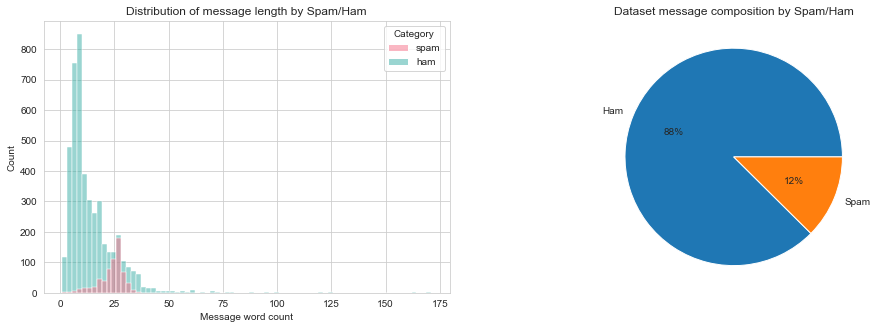

In [103]:
# Plot message length by spam/ham

df_orig['Category'] = pd.Categorical(df_orig['Category'], ['spam','ham'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
sns.histplot(data=df_orig, 
             x="word_count",
             hue="Category",
             palette='husl',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')
colors = sns.color_palette('husl')

ax[1].pie(df_orig.Category.value_counts(normalize=True), labels = ['Ham','Spam'], autopct='%0.f%%')
ax[1].set_title('Dataset message composition by Spam/Ham')
plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [18]:
df_orig.sort_values(by='word_count', ascending=False)

,Category,Message,word_count
1085,ham,For me the love should start with attraction.i...,171
1863,ham,The last thing i ever wanted to do was hurt yo...,162
2158,ham,Sad story of a Man - Last week was my b'day. M...,125
1579,ham,How to Make a girl Happy? It's not at all diff...,121
2434,ham,Indians r poor but India is not a poor country...,119
...,...,...,...
284,ham,Okie...,1
2908,ham,ALRITE,1
2508,ham,Yup...,1
783,ham,Beerage?,1


# Tensorflow Modelling

In [19]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [113]:
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

## Tokenize

In [114]:
# Text tokenization - we have to do this before obtaining the word embeddings 
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# vectorizing text, turning each text into sequence of integers. 
# Default behaviour is to filter all punctuation, plus tabs and line breaks, minus the ' character.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [115]:
X

[[49,
  471,
  4426,
  840,
  755,
  658,
  65,
  8,
  1327,
  88,
  123,
  351,
  1328,
  148,
  2993,
  1329,
  67,
  58,
  4427,
  144],
 [46, 336, 1499, 472, 6, 1940],
 [47,
  489,
  8,
  19,
  4,
  796,
  901,
  2,
  175,
  1941,
  1105,
  659,
  1942,
  2331,
  261,
  2332,
  71,
  1941,
  2,
  1943,
  2,
  337,
  489,
  555,
  960,
  73,
  390,
  179,
  660,
  391,
  2994],
 [6, 247, 150, 23, 381, 2995, 6, 139, 153, 57, 150],
 [1024, 1, 98, 108, 69, 490, 2, 961, 69, 1944, 221, 112, 473],
 [797,
  128,
  67,
  1689,
  145,
  109,
  158,
  2996,
  21,
  7,
  38,
  338,
  89,
  902,
  55,
  116,
  413,
  3,
  44,
  12,
  14,
  85,
  1945,
  46,
  365,
  960,
  4428,
  2,
  68,
  323,
  234,
  2,
  2997],
 [210, 11, 633, 9, 25, 55, 2, 382, 36, 10, 110, 718, 10, 55, 4429, 4430],
 [72,
  235,
  13,
  1204,
  2333,
  2334,
  1946,
  2335,
  2336,
  2337,
  798,
  118,
  109,
  609,
  72,
  13,
  1025,
  12,
  51,
  1690,
  841,
  392,
  2,
  1106,
  13,
  248,
  1025],
 [719,
  72,
  4

In [22]:
# convert to numpy arrays
X = np.array(X)
y = np.array(y)
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH)

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_79182/1587930304.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [23]:
print(X.shape)

(5572, 100)


Discuss what this 100 term is

In [24]:
X

array([[   0,    0,    0, ...,   58, 4427,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  391, 2994],
       ...,
       [   0,    0,    0, ...,  107,  250, 9003],
       [   0,    0,    0, ...,  198,   12,   47],
       [   0,    0,    0, ...,    2,   61,  267]], dtype=int32)

In [25]:
y

array([0, 0, 1, ..., 0, 0, 0])

The below code is not required as I have opted to run this model with a single output node using `binary_crossentropy` rather than two output nodes and `categorical_crossentropy`. I'm going to keep it here just in case I need it later.

In [26]:
# One Hot encoding labels
# [spam, ham, spam, ham, ham] has already been converted to:
# [1, 0, 1, 0, 1] and in the preprocessing, but now to:
# [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]] 
# using to_categorical()

# y = [ label2int[label] for label in y ]
# y = to_categorical(y)

## Train-Test Split

In [27]:
# split and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=7)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (4179, 100)
X_test.shape: (1393, 100)
y_train.shape: (4179,)
y_test.shape: (1393,)


## Word Embedding Using GloVe

I'm using a pre-trained [GloVe word embedding](https://nlp.stanford.edu/projects/glove/) dataset in 100 dimensional space, saved outside of this repository. 

This function opens the GloVe file and maps each of the tokenized words to the corresponding embedded vector. This process works to encode meanings of words in a way that causes words of comparable meaning to be expressed similarly in the defined vector space. More can be read about word embedding [here](https://machinelearningmastery.com/what-are-word-embeddings/).

In [28]:
# https://machinelearningmastery.com/what-are-word-embeddings/
# https://nlp.stanford.edu/projects/glove/

def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"../data/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

## LSTM Model Definition

Define a list of metrics to be sued later in the model definition. These will be calculated and saved after each epoch in the model build for visibility on the modelling process.

In [29]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

2022-03-28 21:32:44.163260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now to define the Keras model. I'm going to do this using the [sequential model API](https://machinelearningmastery.com/keras-functional-api-deep-learning/) where Sequential class is created and model layers are then added to it. The steps I use are as follows:
* Embed the tokenized words
* Add a user defined number of Long Short-Term Memory units 
* Add a Dropout feature of 0.3 to combat over-fitting <-- Bob to find out what this really does
* Output one dense layer with a sigmoid activation function for 1/0 classification
* Compile the model using [binary crossentropy](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) as the loss function and rmsprop optimizer, reporting the extensive list of metrics after each epoch <-- Bob to find out what this really does

With training the model through back-propagation, RNNs famously suffer from the vanishing gradient problem. This means that the RNN would struggle to learn long-range dependencies from the early layers and is often described as a short-term memory problem. To combat this we used specialised units within the hidden layers - Long Short-Term Memory units or LSTMs. These LSTMs are able to learn long-range dependencies through a series of gated tensor operations which dictate what information to add or remove from the hidden state at each unit. 
<br>
<br>
<img src="images/LSTM.png" width=400 height=400 />
<center><sub>This is a graphical representation of a single LSTM unit. The sigma and tanh cells represent sigmoid and hyperbolic tangent functions respectively. X_t and h_t are the input vector and output value of the LSTM unit. </sub></center>

In [30]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 1 output Fully-Connected neurons with sigmoid activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQUENCE_LENGTH))
    # Add long short-term memory units
    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    # Add dropout to combat overfitting
    model.add(Dropout(0.3))
    # Add output dense layer with sigmoid for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=[METRICS])

    model.summary()
    return model

def get_bidirectional_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 1 output Fully-Connected neurons with sigmoid activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQUENCE_LENGTH))
    # Add bidirectional long short-term memory units
    model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=0.2)))
    # Add dropout to combat overfitting
    model.add(Dropout(0.3))
    # Add output dense layer with sigmoid for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=[METRICS])

    model.summary()
    return model

Call the `get_model` function to generate the skeleton - not trained yet.

In [31]:
# constructs the model with 128 LSTM units
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:07, 50572.06it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          900500    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,017,877
Trainable params: 117,377
Non-trainable params: 900,500
_________________________________________________________________


In [32]:
# constructs the bidirectional-model with 128 LSTM units
bimodel = get_bidirectional_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:07, 51118.04it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          900500    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,135,253
Trainable params: 234,753
Non-trainable params: 900,500
_________________________________________________________________


Initialise required TensorBoard callbacks, best model_checkpoints and early stopping. Then fit the model using a batch size and number of epochs defined at the start of section 3. 

### LSTM Model Training

In [33]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              restore_best_weights=True)
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

# My tensorboard source https://www.youtube.com/watch?v=-9-Hy5dWKLE

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.1901 - tp: 368.0000 - fp: 103.0000 - tn: 3521.0000 - fn: 187.0000 - accuracy: 0.9306 - precision: 0.7813 - recall: 0.6631 - auc: 0.9391 - prc: 0.7980
Epoch 1: val_loss improved from inf to 0.12851, saving model to ../results/spam_classifier_0.13.h5
66/66 [==============================] - 12s 127ms/step - loss: 0.1901 - tp: 368.0000 - fp: 103.0000 - tn: 3521.0000 - fn: 187.0000 - accuracy: 0.9306 - precision: 0.7813 - recall: 0.6631 - auc: 0.9391 - prc: 0.7980 - val_loss: 0.1285 - val_tp: 131.0000 - val_fp: 9.0000 - val_tn: 1192.0000 - val_fn: 61.0000 - val_accuracy: 0.9497 - val_precision: 0.9357 - val_recall: 0.6823 - val_auc: 0.9803 - val_prc: 0.9212
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0847 - tp: 477.0000 - fp: 39.0000 - tn: 3585.0000 - fn: 78.0000 - accuracy: 0.9720 - precision: 0.9244 - recall: 0.8595 - auc: 0.9835 - prc: 0.9476
Epoch 2: val_loss improved from 0.12851 to 0.08499

Epoch 13/20
66/66 [==============================] - ETA: 0s - loss: 0.0202 - tp: 535.0000 - fp: 4.0000 - tn: 3620.0000 - fn: 20.0000 - accuracy: 0.9943 - precision: 0.9926 - recall: 0.9640 - auc: 0.9981 - prc: 0.9943
Epoch 13: val_loss did not improve from 0.06317
66/66 [==============================] - 8s 116ms/step - loss: 0.0202 - tp: 535.0000 - fp: 4.0000 - tn: 3620.0000 - fn: 20.0000 - accuracy: 0.9943 - precision: 0.9926 - recall: 0.9640 - auc: 0.9981 - prc: 0.9943 - val_loss: 0.2310 - val_tp: 187.0000 - val_fp: 75.0000 - val_tn: 1126.0000 - val_fn: 5.0000 - val_accuracy: 0.9426 - val_precision: 0.7137 - val_recall: 0.9740 - val_auc: 0.9878 - val_prc: 0.8992
Epoch 14/20
66/66 [==============================] - ETA: 0s - loss: 0.0154 - tp: 541.0000 - fp: 3.0000 - tn: 3621.0000 - fn: 14.0000 - accuracy: 0.9959 - precision: 0.9945 - recall: 0.9748 - auc: 0.9986 - prc: 0.9965
Epoch 14: val_loss did not improve from 0.06317
66/66 [==============================] - 7s 112ms/step - lo

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [34]:
history.history

{'loss': [0.19010651111602783,
  0.08469340205192566,
  0.07266842573881149,
  0.060724373906850815,
  0.051751893013715744,
  0.04719845578074455,
  0.03930741921067238,
  0.03826030716300011,
  0.029866643249988556,
  0.029833471402525902,
  0.026845496147871017,
  0.022970229387283325,
  0.020202836021780968,
  0.01536113303154707,
  0.014840837568044662,
  0.01160439569503069,
  0.009557926096022129,
  0.01179470494389534,
  0.00875623058527708,
  0.005890353582799435],
 'tp': [368.0,
  477.0,
  486.0,
  507.0,
  508.0,
  513.0,
  515.0,
  521.0,
  526.0,
  529.0,
  534.0,
  533.0,
  535.0,
  541.0,
  540.0,
  543.0,
  546.0,
  546.0,
  546.0,
  549.0],
 'fp': [103.0,
  39.0,
  30.0,
  25.0,
  16.0,
  17.0,
  15.0,
  11.0,
  7.0,
  10.0,
  7.0,
  7.0,
  4.0,
  3.0,
  4.0,
  3.0,
  3.0,
  3.0,
  1.0,
  2.0],
 'tn': [3521.0,
  3585.0,
  3594.0,
  3599.0,
  3608.0,
  3607.0,
  3609.0,
  3613.0,
  3617.0,
  3614.0,
  3617.0,
  3617.0,
  3620.0,
  3621.0,
  3620.0,
  3621.0,
  3621.0,
 

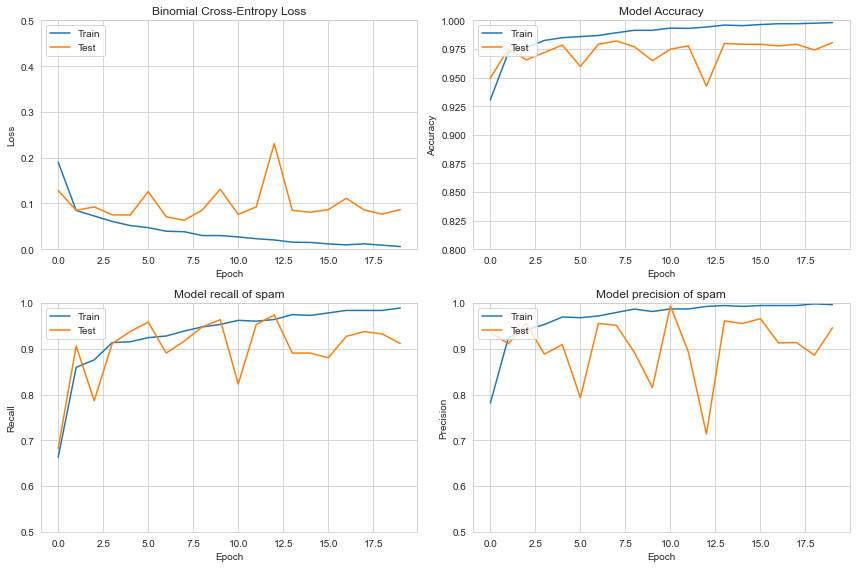

In [35]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.8,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='upper left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='upper left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='upper left')
plt.tight_layout()
plt.show()

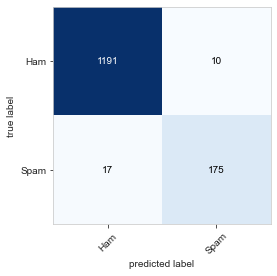

In [36]:
# Plot confusion matrix

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [37]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[5]
precision = result[6]
recall = result[7]

print(f"[+] Accuracy: {accuracy*100:.2f}%")
print(f"[+] Precision:   {precision*100:.2f}%")
print(f"[+] Recall:   {recall*100:.2f}%")

44/44 [==============================] - 1s 15ms/step - loss: 0.0867 - tp: 175.0000 - fp: 10.0000 - tn: 1191.0000 - fn: 17.0000 - accuracy: 0.9806 - precision: 0.9459 - recall: 0.9115 - auc: 0.9760 - prc: 0.9472
[+] Accuracy: 98.06%
[+] Precision:   94.59%
[+] Recall:   91.15%


In [38]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [39]:
int2label = {0: "ham", 1: "spam"}

text = "You won a prize of 1,000$, click here to claim!"
get_predictions(text)

'ham'

In [40]:
text = "Hi man, I was wondering if we can meet tomorrow."
print(get_predictions(text))

ham


In [41]:
probs = list(model.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

In [42]:
dfpred

,true,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1388,0,0
1389,0,0
1390,1,1
1391,1,1


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

print(confusion_matrix(dfpred.true, dfpred.pred))
print('Accuracy',accuracy_score(dfpred.true, dfpred.pred))
print('Recall',recall_score(dfpred.true, dfpred.pred))
print('Precision',precision_score(dfpred.true, dfpred.pred))

[[1191   10]
 [  17  175]]
Accuracy 0.9806173725771715
Recall 0.9114583333333334
Precision 0.9459459459459459


[Intersting link on explaining feature importance, although I don't know how it will work with the word embedder](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)

### Bidirectional LSTM Model Training

In [44]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              restore_best_weights=True)
# train the model
history = bimodel.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

# My tensorboard source https://www.youtube.com/watch?v=-9-Hy5dWKLE

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.1757 - tp: 552.0000 - fp: 91.0000 - tn: 4734.0000 - fn: 195.0000 - accuracy: 0.9487 - precision: 0.8585 - recall: 0.7390 - auc: 0.9588 - prc: 0.8673
Epoch 1: val_loss improved from inf to 0.34552, saving model to ../results/spam_classifier_0.35.h5
66/66 [==============================] - 19s 223ms/step - loss: 0.1757 - tp: 552.0000 - fp: 91.0000 - tn: 4734.0000 - fn: 195.0000 - accuracy: 0.9487 - precision: 0.8585 - recall: 0.7390 - auc: 0.9588 - prc: 0.8673 - val_loss: 0.3455 - val_tp: 191.0000 - val_fp: 198.0000 - val_tn: 1003.0000 - val_fn: 1.0000 - val_accuracy: 0.8571 - val_precision: 0.4910 - val_recall: 0.9948 - val_auc: 0.9862 - val_prc: 0.9087
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0930 - tp: 481.0000 - fp: 49.0000 - tn: 3575.0000 - fn: 74.0000 - accuracy: 0.9706 - precision: 0.9075 - recall: 0.8667 - auc: 0.9823 - prc: 0.9399
Epoch 2: val_loss improved from 0.34552 to 0.09581,

Epoch 13/20
66/66 [==============================] - ETA: 0s - loss: 0.0191 - tp: 538.0000 - fp: 3.0000 - tn: 3621.0000 - fn: 17.0000 - accuracy: 0.9952 - precision: 0.9945 - recall: 0.9694 - auc: 0.9972 - prc: 0.9938
Epoch 13: val_loss did not improve from 0.07171
66/66 [==============================] - 13s 202ms/step - loss: 0.0191 - tp: 538.0000 - fp: 3.0000 - tn: 3621.0000 - fn: 17.0000 - accuracy: 0.9952 - precision: 0.9945 - recall: 0.9694 - auc: 0.9972 - prc: 0.9938 - val_loss: 0.0805 - val_tp: 168.0000 - val_fp: 6.0000 - val_tn: 1195.0000 - val_fn: 24.0000 - val_accuracy: 0.9785 - val_precision: 0.9655 - val_recall: 0.8750 - val_auc: 0.9789 - val_prc: 0.9599
Epoch 14/20
66/66 [==============================] - ETA: 0s - loss: 0.0182 - tp: 540.0000 - fp: 6.0000 - tn: 3618.0000 - fn: 15.0000 - accuracy: 0.9950 - precision: 0.9890 - recall: 0.9730 - auc: 0.9983 - prc: 0.9939
Epoch 14: val_loss did not improve from 0.07171
66/66 [==============================] - 13s 202ms/step - 

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [45]:
history.history

{'loss': [0.1757383644580841,
  0.09303231537342072,
  0.0725015178322792,
  0.059207357466220856,
  0.053070053458213806,
  0.048637405037879944,
  0.0385836586356163,
  0.03525902330875397,
  0.03182343393564224,
  0.02838868647813797,
  0.02756495028734207,
  0.02164548821747303,
  0.01914259046316147,
  0.01822899654507637,
  0.01788443885743618,
  0.01488289050757885,
  0.01116474624723196,
  0.011131096631288528,
  0.009438585489988327,
  0.010220869444310665],
 'tp': [552.0,
  481.0,
  493.0,
  501.0,
  508.0,
  516.0,
  516.0,
  519.0,
  523.0,
  528.0,
  534.0,
  540.0,
  538.0,
  540.0,
  540.0,
  545.0,
  541.0,
  546.0,
  548.0,
  545.0],
 'fp': [91.0,
  49.0,
  28.0,
  22.0,
  16.0,
  25.0,
  10.0,
  9.0,
  9.0,
  6.0,
  8.0,
  6.0,
  3.0,
  6.0,
  6.0,
  8.0,
  3.0,
  6.0,
  3.0,
  4.0],
 'tn': [4734.0,
  3575.0,
  3596.0,
  3602.0,
  3608.0,
  3599.0,
  3614.0,
  3615.0,
  3615.0,
  3618.0,
  3616.0,
  3618.0,
  3621.0,
  3618.0,
  3618.0,
  3616.0,
  3621.0,
  3618.0,
 

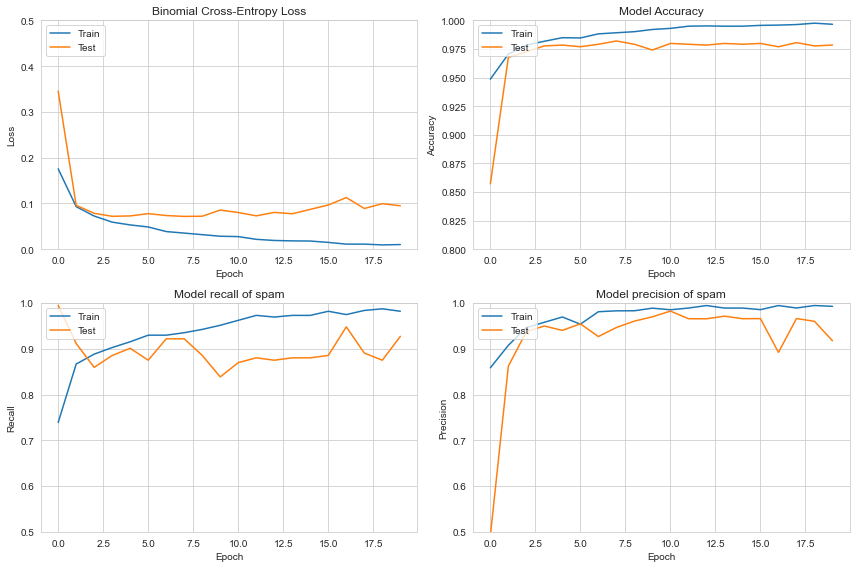

In [46]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.8,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='upper left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='upper left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='upper left')
plt.tight_layout()
plt.show()

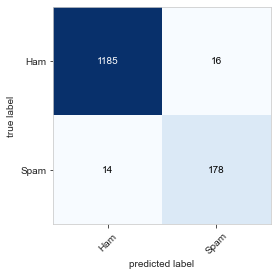

In [47]:
y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

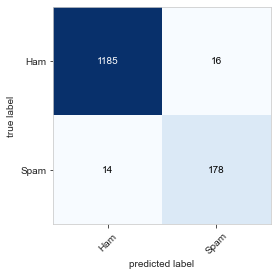

In [48]:
# Plot confusion matrix

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [49]:
# get the loss and metrics
result = bimodel.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[5]
precision = result[6]
recall = result[7]

print(f"[+] Accuracy: {accuracy*100:.2f}%")
print(f"[+] Precision:   {precision*100:.2f}%")
print(f"[+] Recall:   {recall*100:.2f}%")

44/44 [==============================] - 1s 24ms/step - loss: 0.0950 - tp: 178.0000 - fp: 16.0000 - tn: 1185.0000 - fn: 14.0000 - accuracy: 0.9785 - precision: 0.9175 - recall: 0.9271 - auc: 0.9845 - prc: 0.9479
[+] Accuracy: 97.85%
[+] Precision:   91.75%
[+] Recall:   92.71%


In [50]:
probs = list(bimodel.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

In [51]:
# Sklearn metrics

print(confusion_matrix(dfpred.true, dfpred.pred))
print('Accuracy',accuracy_score(dfpred.true, dfpred.pred))
print('Recall',recall_score(dfpred.true, dfpred.pred))
print('Precision',precision_score(dfpred.true, dfpred.pred))

[[1185   16]
 [  14  178]]
Accuracy 0.9784637473079684
Recall 0.9270833333333334
Precision 0.9175257731958762


# Nice Word Clouds

In [52]:
vectorizer = CountVectorizer(token_pattern='[A-Za-z0-9]+(?=\\s+)',
                             ngram_range=(1,2))

In [53]:
vectorizer.fit(df.message)

CountVectorizer(ngram_range=(1, 2), token_pattern='[A-Za-z0-9]+(?=\\s+)')

In [54]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [55]:
# sort words by frequency
from operator import itemgetter

def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [56]:
stop = stopwords.words('english')

# Series text column
tvec = TfidfVectorizer(stop_words = stop,
                       ngram_range = (1, 2),
                       max_features = 1000,
                       token_pattern = '[A-Za-z0-9]+(?=\\s+)',
                        )

# Fit vectorizer on text data
tvec.fit(df.message)

# Transform data
tvec_mat = tvec.transform(df.message)

# words occuring
words = tvec.get_feature_names_out()

# count word appearances
csum= word_counter(tvec_mat)

In [57]:
# sort words by frequency
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=["word", "frequency_series"])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.index.name = None
df_word_frequency.head(20)

,frequency_series
u,202.879967
call,147.794835
get,113.840056
2,97.044550
ur,92.282646
come,86.105870
like,84.654699
got,83.499020
go,79.663331
know,75.688012


There are 453387 unique words in all the descriptions.


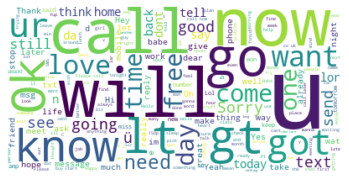

In [58]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word cloud
wc_all = WordCloud(stopwords=stopwords,
                                  max_words=200,
                                  background_color="white")

# generate a word cloud image
wc_all.generate(wrds_cnt)

# display the generated image
plt.imshow(wc_all, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 103824 unique words in all the descriptions.


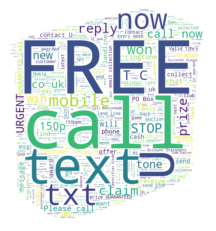

In [59]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_spam.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_spam = np.array(Image.open('images/spam2.png'))

# create word cloud
wc_spam = WordCloud(stopwords=STOPWORDS,
               mask=mask_spam, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_spam.shape[1],
               height=mask_spam.shape[0])
wc_spam.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_spam, interpolation="bilinear")
plt.axis('off')
plt.show()

There are 349562 unique words in all the descriptions.


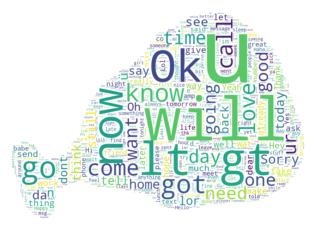

In [60]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_ham.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_ham = np.array(Image.open('images/ham2.png'))

# create word cloud
wc_ham = WordCloud(stopwords=STOPWORDS,
               mask=mask_ham, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_ham.shape[1],
               height=mask_ham.shape[0])
wc_ham.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_ham, interpolation="bilinear")
plt.axis('off')
plt.show()

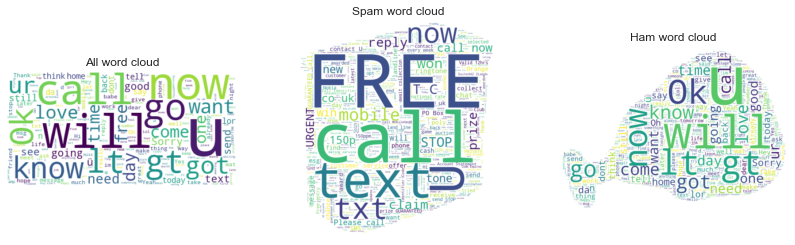

In [121]:
# combine all wordcloud plots
sns.set_style("white")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
ax[0].imshow(wc_all, interpolation="bilinear")
ax[0].set_title('All word cloud')
ax[1].imshow(wc_spam, interpolation="bilinear")
ax[1].set_title('Spam word cloud')
ax[2].imshow(wc_ham, interpolation="bilinear")
ax[2].set_title('Ham word cloud')
fig.set_facecolor("white")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.savefig('images/cloud.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [62]:
# def get_model(tokenizer, lstm_units):
#     """
#     Constructs the model,
#     Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
#     """
#     # get the GloVe embedding vectors
#     embedding_matrix = get_embedding_vectors(tokenizer)
#     # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
#     model = Sequential()
#     # First, embed the words using loaded GloVe
#     model.add(Embedding(len(tokenizer.word_index)+1,
#               EMBEDDING_SIZE,
#               weights=[embedding_matrix],
#               trainable=False,
#               input_length=SEQUENCE_LENGTH))
#     # Add long short-term memory units
#     model.add(LSTM(lstm_units, recurrent_dropout=0.2))
#     # Add dropout to combat overfitting
#     model.add(Dropout(0.3))
#     # Add output dense layer with softmax for 1/0 classification
#     model.add(Dense(2, activation="softmax"))
#     # compile as rmsprop optimizer
#     # aswell as with recall metric
#     model.compile(optimizer="rmsprop", 
#                   loss="categorical_crossentropy",
#                   metrics=["accuracy", 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()])

#     model.summary()
#     return model
